In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2.4.1


In [3]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [3]:
class CustomCallback_epoch(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # list of weight tensors
        curr_weight = self.model.get_weights()
        if weight_history:
          weight_change = [curr_weight[i] - weight_history[-1][i] for i in range(len(curr_weight))]
          print('MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH')
          print([tf.reduce_mean(t).numpy() for t in weight_change])
        weight_history.append(self.model.get_weights())

In [18]:
# records only the mean change per layer, saving the whole weight matrix per batch takes too much memory
# first element reserved for the weights of the previous batch, remove before use
class CustomCallback_batch(tf.keras.callbacks.Callback):
      def on_train_batch_begin(self, batch, logs=None):
        # list of weight tensors
        curr_weight = self.model.get_weights()
        if weight_history:
          weight_change = [curr_weight[i] - weight_history[0][i] for i in range(len(curr_weight))]
          # print('MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH')
          # print([tf.reduce_mean(t).numpy() for t in weight_change])
          weight_history.append([tf.reduce_mean(t).numpy() for t in weight_change])
          weight_history[0] = curr_weight
        else:
          weight_history.append(curr_weight)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6014 - accuracy: 0.8259 - val_loss: 0.1866 - val_accuracy: 0.9467
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1730 - accuracy: 0.9492 - val_loss: 0.1251 - val_accuracy: 0.9644
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1127 - 

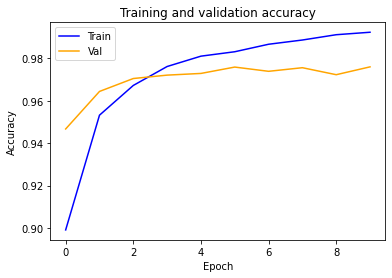

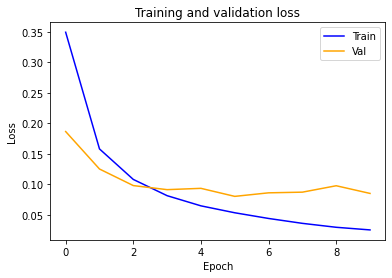

In [22]:
# this initializer uses 0.0025 as stddev, should trigger active training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0025, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_active = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

print(model_active.summary())

model_active.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_active.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[CustomCallback_batch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_active.predict(x_test), axis=1)))

active_weight_history = weight_history[1:]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 55.0922 - accuracy: 0.5288 - val_loss: 8.5796 - val_accuracy: 0.8526
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 7.5082 - accuracy: 0.8588 - val_loss: 5.4841 - val_accuracy: 0.8875
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 4.6952 -

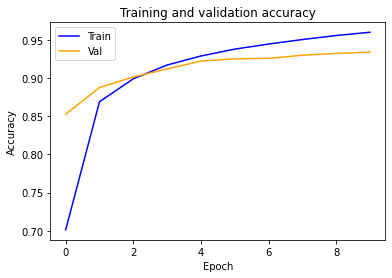

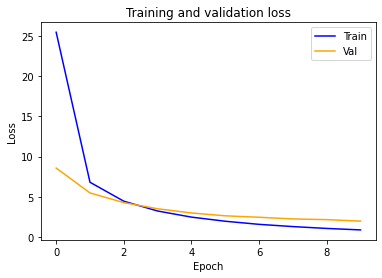

In [24]:
# this initializer uses sqrt(2) as stddev, much higher than default, should trigger lazy training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.414, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_lazy = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

print(model_lazy.summary())

model_lazy.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_lazy.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[CustomCallback_batch()])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

lazy_weight_history = weight_history[1:]

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7048 - accuracy: 0.8350 - val_loss: 0.3069 - val_accuracy: 0.9151
Epoch 2/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.043098412, 7.813275e-05]
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3122 - accuracy: 0.9139 - val_loss: 0.2792 - val_accuracy: 0.9229
Epoch 3/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.014823606, 0.0028685182]
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2841 - accuracy: 0.9216 - val_loss: 0.2728 - val_accuracy: 0.9237
Epoch 4/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.012849088, 0.0010896683]
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2711 - accuracy: 0.9254 - val_loss: 0.2682 - val_accuracy: 0.9257
Epoch 5/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.011949384, 0.0014608115]
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2655 - accuracy: 0.9249 - val_

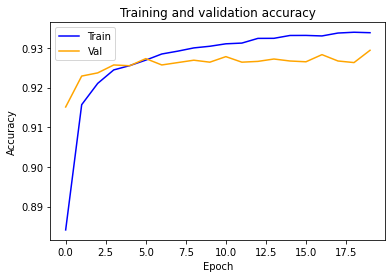

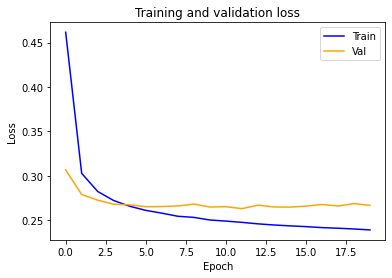

In [39]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0025, seed=20000)

linear_low_var_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

linear_low_var_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = linear_low_var_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[CustomCallback_batch()])

plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

linear_low_var_weight_history = weight_history

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 8.6248 - accuracy: 0.3000 - val_loss: 1.7823 - val_accuracy: 0.7284
Epoch 2/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.035041347, 0.025263865]
1875/1875 [==============================] - 3s 1ms/step - loss: 1.5506 - accuracy: 0.7528 - val_loss: 1.1432 - val_accuracy: 0.8171
Epoch 3/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.011539796, 0.0019838333]
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0525 - accuracy: 0.8252 - val_loss: 0.9154 - val_accuracy: 0.8466
Epoch 4/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.0076834164, 0.0020698428]
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8626 - accuracy: 0.8503 - val_loss: 0.7936 - val_accuracy: 0.8595
Epoch 5/20
MEAN WEIGHT CHANGE FOR EACH LAYER OVER LAST EPOCH
[-0.006253115, 0.0006540641]
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7459 - accuracy: 0.8664 - val_

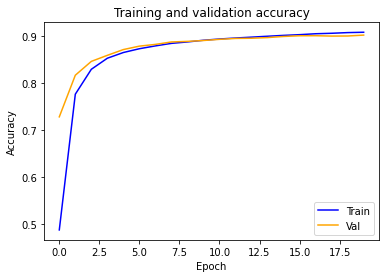

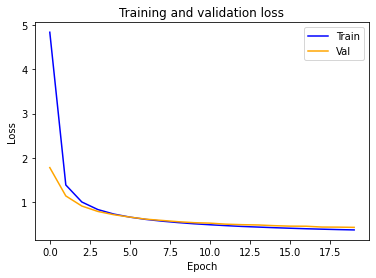

In [40]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.414, seed=20000)

linear_high_var_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

weight_history = []

linear_high_var_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = linear_high_var_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[CustomCallback_batch()])

plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_lazy.predict(x_test), axis=1)))

linear_high_var_weight_history = weight_history

In [9]:
def incremental_weight_change(weight_history):
  return [[weight_history[i][j] - weight_history[i-1][j] for j in range(len(weight_history[i]))] for i in range(1,len(weight_history))]

In [10]:
def avg_weight_change(weight_history):
  return [[tf.reduce_mean(weight_history[i][j] - weight_history[i-1][j]).numpy() for j in range(len(weight_history[i]))] for i in range(1,len(weight_history))]

In [11]:
def avg_weight_change_over_time(weight_history):
  return np.mean(np.array(avg_weight_change(weight_history)))

In [12]:
def batch_avg_weight_change_over_time(weight_history):
  return np.mean(np.array(weight_history))

In [55]:
# epoch level
avg_weight_change_over_time(linear_low_var_weight_history)

-0.005216999

In [54]:
# epoch level
avg_weight_change_over_time(linear_high_var_weight_history)

-0.003043227

In [56]:
# epoch level
avg_weight_change_over_time(active_weight_history)

-0.0009094894

In [57]:
# epoch level
avg_weight_change_over_time(lazy_weight_history)

-0.0019097058

In [25]:
# batch level
batch_avg_weight_change_over_time(active_weight_history)

-3.5230588e-07

In [26]:
# batch level
batch_avg_weight_change_over_time(lazy_weight_history)

-1.8613964e-06

In [ ]:
# batch level
avg_weight_change_over_time(linear_low_var_weight_history)

In [58]:
# batch level
avg_weight_change_over_time(linear_high_var_weight_history)

[[array([[-1.108878  ,  0.80818945, -1.19348   , ...,  3.1202936 ,
           2.2615795 , -0.9673594 ],
         [-0.17873676,  1.0973226 , -2.9093163 , ...,  0.4209159 ,
           1.1459633 , -1.1144615 ],
         [-2.8458667 , -0.52034795, -0.24678332, ...,  1.3652748 ,
           1.6443253 ,  1.8529853 ],
         ...,
         [-0.72356707, -2.8412018 ,  0.26231056, ...,  0.61609817,
           0.13318811,  0.2473633 ],
         [ 0.79167044, -1.4235656 , -0.212689  , ..., -0.27383056,
          -0.7938624 , -1.6978672 ],
         [ 2.5059986 , -3.1166353 ,  0.78126115, ...,  1.0535119 ,
          -1.1376019 , -1.6792926 ]], dtype=float32),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 